### MSc Data Analytics 

##### CA2 - Integrated Assignment sem2

#### 2020274 - Clarissa Cardoso





This Notebook contains experimental features for CA2 using different databases to store and retreat files from. The goal of this project is to combine language processing techniques and a time series forecasting to predict the average sentiment of tweets for a certein period of time after the apropriate data cleaning and processing tecniques are applied.

Fpr a better understanding the project will be divided into the following sections:

- First section consists of importing dataset from various databases, and an attemp to evaluate their performance and usability, helping to select the most suitable dataset for the analysis.

- Second section will focus on data cleaning and preprocessing the dataset

- Third section focus on deeper EDA features and Natural Language Processing to undertand the dataset better prior to modeling and extract the sentiment from tweets given.

- Section four centers on creating the time-series model and selection of apropriate parametrers and hyperparameters to run it.

- Fifth section relies on training the model and validating/reacessing features that can be modified for better performance and compare model's results. 






#### Introduction


The goal of this project is to perform an analysis of the given dataset containing several tweets while experimenting with different databases to store data as well as creating a  time series forecast of the sentiment of the dataset. 

For the initial experimentation, after instalation of different noSQL databases as seen in class tutorials, I have decided to start with Hbase. One of the reasons why this was the first database used for the project is that it is built on top of HDFS as a part of Hadoop environment and provides a faster lookup on files while displaying lower latency for queries. 



### Libraries required for project


In [1]:
# importing necessary libraries to deploy pyspark functions

from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.functions import udf # Imports function UDF (user defined functions).
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import max as max_


from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector

from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from bs4 import BeautifulSoup  # For HTML parsing
from pyspark.sql.functions import lower

import numpy as np # for numerical operations.
import pandas as pd

import matplotlib.pyplot as plt # visualization
%matplotlib inline 

import warnings # Ignore warnings.
warnings.filterwarnings("ignore")

#### Importing dataset from HDFS

My initial idea, once the dataset given was succesfuly stored in HDFS directory alocated for the CA development ("CA2/ProjectTweets.csv"), was to import it straighaway to a noSQL database and perform initial queries inside the HBase enviroment/shell to verify functionality.

However my VM had continuous crashes during this process, and the HMaster node managed by Zookeeper kept showing slower times for initializing the commands. After a few seconds the Zookeeper Connection with HDFS and Hase nodes was lost and it was taking me a longer time span to find an alternative. Since the csv file was already in hadoop, I decided to first import from HDFS and the perform some initial cleaning and EDA using Spark framework to process the data to then store the cleneaded data back to HBAse through a connector between Pyspark and the database.


- HDFS (Hadoop Distributed File System) is the primary storage system used by Hadoop applications. This open source framework works by rapidly transferring data between nodes. It's often used by companies who need to handle and store big data. <https://www.databricks.com/glossary>

## Import modules, create Spark Session and read file into dataframe

First step is to perform some basic exploratory data analysis to get a sense of the data. 

#### Check the first few rows of the dataset with .show()

File was imported with a header marked as 'false' so pyspark will input labels insted of using the first row. This makes room to rename the labels in coming steps. set up schema as true so pyspark utilises the same scema present in the original file, without overlapping the columns.



In [2]:
from pyspark.sql import SparkSession

# Initialize SparkSession including Legacy for timestamp
spark = SparkSession.builder.appName("Test Tweets")\
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4")\
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrator", "com.johnsnowlabs.nlp.serialization.SparkNLPKryoRegistrator") \
    .getOrCreate()

# Define the file path in HDFS
file_path = "hdfs:///user/hduser/CA2/ProjectTweets.csv"

# Read the CSV file
tweets_test = spark.read.csv(file_path, header=False, inferSchema=True)

# Show the DataFrame (optional)
tweets_test.show()


+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

#### Checking the schema of the dataset

From this function we see most of the data is composed by strings, which makes sense, since we are working with mostly text. However, on the third column, with the dates of each tweet, we must have a datetime datatype in order to perform the timeseries analysis on further stages. 



In [3]:
# print schema
tweets_test.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: long (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



In [4]:
# get summary statistics
tweets_test.describe().show()

+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|summary|               _c0|                 _c1|                 _c2|     _c3|                 _c4|                 _c5|
+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|  count|           1600000|             1600000|             1600000| 1600000|             1600000|             1600000|
|   mean|          799999.5|1.9988175522956276E9|                null|    null| 4.325887521835714E9|                null|
| stddev|461880.35968924535|1.9357607362267256E8|                null|    null|5.162733218454889E10|                null|
|    min|                 0|          1467810369|Fri Apr 17 20:30:...|NO_QUERY|        000catnap000|                 ...|
|    max|           1599999|          2329205794|Wed May 27 07:27:...|NO_QUERY|          zzzzeus111|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|
+-------+---------------

### Part I : Data Pre-Processing and Cleaning


Rename cols and drop c1

Convert the date column to a timestamp format

In [5]:
from pyspark.sql.functions import to_timestamp

tweets_test = tweets_test.drop("_c1") \
           .withColumnRenamed("_c0", "index") \
           .withColumnRenamed("_c2", "date") \
           .withColumnRenamed("_c3", "query_flag") \
           .withColumnRenamed("_c4", "user") \
           .withColumnRenamed("_c5", "text") \

tweets_test.show()

+-----+--------------------+----------+---------------+--------------------+
|index|                date|query_flag|           user|                text|
+-----+--------------------+----------+---------------+--------------------+
|    0|Mon Apr 06 22:19:...|  NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    1|Mon Apr 06 22:19:...|  NO_QUERY|  scotthamilton|is upset that he ...|
|    2|Mon Apr 06 22:19:...|  NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|Mon Apr 06 22:19:...|  NO_QUERY|        ElleCTF|my whole body fee...|
|    4|Mon Apr 06 22:19:...|  NO_QUERY|         Karoli|@nationwideclass ...|
|    5|Mon Apr 06 22:20:...|  NO_QUERY|       joy_wolf|@Kwesidei not the...|
|    6|Mon Apr 06 22:20:...|  NO_QUERY|        mybirch|         Need a hug |
|    7|Mon Apr 06 22:20:...|  NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|    8|Mon Apr 06 22:20:...|  NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|    9|Mon Apr 06 22:20:...|  NO_QUERY|        mimismo|@twittera que me ...|

View a sample of the 'date' column, using the sample() function to double check the timezone used before conversion.


In [6]:
# see 10% of date row to see correct timezone before converting
tweets_test.select("date").sample(False, 0.1, seed=42).show()


+--------------------+
|                date|
+--------------------+
|Mon Apr 06 22:20:...|
|Mon Apr 06 22:20:...|
|Mon Apr 06 22:20:...|
|Mon Apr 06 22:22:...|
|Mon Apr 06 22:22:...|
|Mon Apr 06 22:23:...|
|Mon Apr 06 22:23:...|
|Mon Apr 06 22:23:...|
|Mon Apr 06 22:25:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:27:...|
|Mon Apr 06 22:27:...|
|Mon Apr 06 22:28:...|
|Mon Apr 06 22:28:...|
|Mon Apr 06 22:31:...|
+--------------------+
only showing top 20 rows



In [7]:
# limit to 10 rows of date col.
sample_date_values = tweets_test.select("date").limit(10).collect()
for row in sample_date_values:
    print(row.date)

    #with this we can confirm the PDT - Pacific Day Time for apropriate conversion to timestamp.
    # this may influence further analysis. 

Mon Apr 06 22:19:45 PDT 2009
Mon Apr 06 22:19:49 PDT 2009
Mon Apr 06 22:19:53 PDT 2009
Mon Apr 06 22:19:57 PDT 2009
Mon Apr 06 22:19:57 PDT 2009
Mon Apr 06 22:20:00 PDT 2009
Mon Apr 06 22:20:03 PDT 2009
Mon Apr 06 22:20:03 PDT 2009
Mon Apr 06 22:20:05 PDT 2009
Mon Apr 06 22:20:09 PDT 2009


it's important to account for the PDT timezone used. When converting to datetime, the new schema was in the apropriate datatypes, however when i tried to sample the 'date' rows again i got an error as seen below: 

> <font color='red'> <b>Py4JJavaError:</b> An error occurred while calling o100.showString.
: org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to recognize 'EEE MMM dd HH:mm:ss z yyyy' pattern in the DateTimeFormatter. 1) You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0. 2) You can form a valid datetime pattern with the guide from https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html </font> 

So according to Apache Spark documentation, I added a date parsing from java with SimpleDateFormat class to allow customization of the date format of the strings. For that the timezone needs to be specified to avoid any discrepancies. In this case, PDT is UTC-7 which is represented by 'z' in the Apache datetime patterns doc. 


In [8]:
from pyspark.sql.functions import to_timestamp

tweets_test = tweets_test.withColumn("date", to_timestamp(tweets_test.date, "EEE MMM dd HH:mm:ss z yyyy"))


In [9]:
# print schema
tweets_test.printSchema()

root
 |-- index: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- query_flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



#### Checking for missing values and shape


In [10]:
from pyspark.sql.functions import count, when, col
# Check for missing values in each column
tweets_test.select([count(when(col(c).isNull(), c)).alias(c) for c in tweets_test.columns]).show()

+-----+----+----------+----+----+
|index|date|query_flag|user|text|
+-----+----+----------+----+----+
|    0|   0|         0|   0|   0|
+-----+----+----------+----+----+



In [11]:
# print the sahpe of the dataset
num_rows = tweets_test.count()
num_cols = len(tweets_test.columns)

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_cols}")

Number of Rows: 1600000
Number of Columns: 5


In [12]:
tweets_test.dropna()  # Drop rows containing NaN values for simplicity
tweets_test.show(5)

+-----+-------------------+----------+---------------+--------------------+
|index|               date|query_flag|           user|                text|
+-----+-------------------+----------+---------------+--------------------+
|    0|2009-04-07 05:19:45|  NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    1|2009-04-07 05:19:49|  NO_QUERY|  scotthamilton|is upset that he ...|
|    2|2009-04-07 05:19:53|  NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|2009-04-07 05:19:57|  NO_QUERY|        ElleCTF|my whole body fee...|
|    4|2009-04-07 05:19:57|  NO_QUERY|         Karoli|@nationwideclass ...|
+-----+-------------------+----------+---------------+--------------------+
only showing top 5 rows



#### Pyspark has some inbuilt functions for starting tne text processing, such as lowercasing, removing special characters and stopwords. 

The following text data preprocessing steps using PySpark functions are:

Lowercasing: We use the lower() function to convert all text to lowercase.

Removing Special Characters: We use regexp_replace() to remove any characters that are not alphanumeric or whitespace.

Removing Stopwords: We use the StopWordsRemover from the pyspark.ml.feature module to remove common stopwords.

The resulting DataFrame tweets_test will have the preprocessed text in the 'text' column.

PySpark doesn't have built-in support for stemming or lemmatization. To implement these kind of techniques, external libraries such as nltk can be implemented/imported. 
<b>NLTK<b/> provides a wide range of tools and resources for working with human language data, and it can complement Spark's capabilities in certain scenarios. 

However, when i tried to import the nltk functions to my vm, i encountered a series of incompatibility issues. Even after creating a virtual environment i was not able to install the library, and the same happened when i tried to install <b>Sparknlp<b/>, which is the language processing tool whitin the Spark enviroment considered to be the state of the art for a number of functionalities in the NLP area. 

There was also an attempt, as suggested by SparkNLP documentaroin, to inicialize pyspark with the additional packages for language processing but when i tried to import it back to the notebook it would not find the module installed, even when i apply the same command (pyspark --packages com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4) to the virtual env the packages were installed. A third nlp library was also atempted to import via pip: <b>textblob<b/>
    
#error: externally-managed-environment (#error: externally-managed-environment)

With the command found in stackoverflow (sudo apt install python3-nltk) available at https://askubuntu.com/questions/996185/how-can-i-install-nltk-for-python-3

i was able to go back to my original choice of applying nltk tools for extracting the sentiment of the tweets given.

In [13]:
#pip install beautifulsoup4 using virtual enviroment 'myenv'

Tokenization is performed using the Tokenizer class.

HTML parsing is done using the BeautifulSoup library, and a user-defined function (parse_html_udf) is registered and applied to create a new column named "cleaned_text."

A user-defined function is applied to remove special characters and numbers from the "cleaned_text" column.
Stop words are removed using the StopWordsRemover class.

In [14]:


# Convert text to lowercase
#df_cleaned = df_cleaned.withColumn('cleaned_words', lower('cleaned_words'))

# Remove duplicate rows based on the 'cleaned_words' column
#df_cleaned = df_cleaned.dropDuplicates(['cleaned_words'])

# Remove rows with empty 'cleaned_words'
#df_cleaned = df_cleaned.filter(df_cleaned.cleaned_words != '')

# Show the result
#df_cleaned.show(5,truncate=False)

Removing noise from data: 
    -Stop words
    -Special characters
    -transform all to lower case letters
    -remove numbers, duplicate characters and punctuation

In [15]:
# Remove URLs
tweets_test = tweets_test.withColumn("text", F.regexp_replace(F.col("text"), "http(s)?://[^\\s]+", ""))

# Remove HTML tags
tweets_test = tweets_test.withColumn("text", F.regexp_replace(F.col("text"), "<[^>]+>", ""))

# Remove mentions (i.e., @username)
tweets_test = tweets_test.withColumn("text", F.regexp_replace(F.col("text"), "@\\w+", ""))

# Convert to lowercase
tweets_test = tweets_test.withColumn('text', lower(tweets_test['text']))

# Remove numbers from the "text" column
tweets_test = tweets_test.withColumn('text', regexp_replace(tweets_test['text'], r'\d+', ''))

# Reduce excessive characters (more than two of the same in a row)
tweets_test = tweets_test.withColumn('text', regexp_replace('text', r'(.)\1{2,}', r'\1\1'))

# Remove punctuation
tweets_test = tweets_test.withColumn('text', regexp_replace(tweets_test['text'], r"[^\w\s]", ""))

tweets_test.select("text").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+
|text                                                                                                       |
+-----------------------------------------------------------------------------------------------------------+
|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                  |
|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah|
| i dived many times for the ball managed to save   the rest go out of bounds                               |
|my whole body feels itchy and like its on fire                                                             |
| no its not behaving at all im mad why am i here because i cant see you all over there                     |
| not the whole crew                                                                                        |
|need a hu

In [16]:
# Drop the 'flag' and 'user' columns
tweets_test = tweets_test.drop('query_flag', 'user')

# Show the result
tweets_test.show(5,truncate=False)

+-----+-------------------+-----------------------------------------------------------------------------------------------------------+
|index|date               |text                                                                                                       |
+-----+-------------------+-----------------------------------------------------------------------------------------------------------+
|0    |2009-04-07 05:19:45|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                  |
|1    |2009-04-07 05:19:49|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah|
|2    |2009-04-07 05:19:53| i dived many times for the ball managed to save   the rest go out of bounds                               |
|3    |2009-04-07 05:19:57|my whole body feels itchy and like its on fire                                                             |
|4    |2009-04-07 05:19:57| no its not behaving 

### Write Cleaned dataset in a new csv back to hdfs. 

with code adapted from SparkByExamples[], let's store the cleaned tweets to a new csv file back to hdfs. 
This will be later on imported to mysql for testing different databases. the code will be left eith comments just to protect the vm, and avoid overwriting the files in case the kernel is restarted. 

[] https://sparkbyexamples.com/spark/spark-write-dataframe-to-csv-file/#:~:text=In%20Spark%2C%20you%20can%20save,any%20Spark%20supported%20file%20systems.

In [17]:
# The path in HDFS where you want to save the new DataFrame
#new_file_path = "hdfs:///user/hduser/CA2/CleanTweets.csv"

# Save the DataFrame to HDFS as a CSV file
#tweets_test.write.csv(new_file_path, header=True, mode="overwrite")

In [18]:
# The path in HDFS where you want to store the clean DataFrame
#output_directory = "hdfs:///user/hduser/CA2"

# Save the DataFrames to HDFS as CSV files
#tweets_test.write.csv(f"{output_directory}/CleanTweets", header=True, mode="overwrite")

In [19]:
# Show the result
tweets_test.show(truncate=False)

+-----+-------------------+-----------------------------------------------------------------------------------------------------------+
|index|date               |text                                                                                                       |
+-----+-------------------+-----------------------------------------------------------------------------------------------------------+
|0    |2009-04-07 05:19:45|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                  |
|1    |2009-04-07 05:19:49|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah|
|2    |2009-04-07 05:19:53| i dived many times for the ball managed to save   the rest go out of bounds                               |
|3    |2009-04-07 05:19:57|my whole body feels itchy and like its on fire                                                             |
|4    |2009-04-07 05:19:57| no its not behaving 

## Convert to pandas df for apply nltk:


In [20]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = tweets_test.toPandas()

# Now 'pandas_df' is a Pandas DataFrame
# You can apply NLTK or other Python libraries on 'pandas_df' as needed

In [21]:
display(pandas_df.head())
print(pandas_df.info())

,index,date,text
0,0,2009-04-07 05:19:45,a11 thats a bummer you shoulda got david c...
1,1,2009-04-07 05:19:49,is upset that he cant update his facebook by t...
2,2,2009-04-07 05:19:53,i dived many times for the ball managed to sa...
3,3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire
4,4,2009-04-07 05:19:57,no its not behaving at all im mad why am i he...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   index   1600000 non-null  int32         
 1   date    1600000 non-null  datetime64[ns]
 2   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 30.5+ MB
None


### Text Preprocessing for sentiment extraction using NLTK library
"Text preprocessing is a crucial step in performing sentiment analysis, as it helps to clean and normalize the text data, making it easier to analyze. The preprocessing step involves a series of techniques that help transform raw text data into a form you can use for analysis. Some common text preprocessing techniques include tokenization, stop word removal, stemming, and lemmatization."https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

### Tokenization
Tokenization is a text preprocessing step in sentiment analysis that involves breaking down the text into individual words or tokens. This is an essential step in analyzing text data as it helps to separate individual words from the raw text, making it easier to analyze and understand. Tokenization is typically performed using NLTK's built-in `word_tokenize` function, which can split the text into individual words and punctuation marks.

### Stop words
Stop word removal is a crucial text preprocessing step in sentiment analysis that involves removing common and irrelevant words that are unlikely to convey much sentiment. Stop words are words that are very common in a language and do not carry much meaning, such as "and," "the," "of," and "it." These words can cause noise and skew the analysis if they are not removed.

By removing stop words, the remaining words in the text are more likely to indicate the sentiment being expressed. This can help to improve the accuracy of the sentiment analysis. NLTK provides a built-in list of stop words for several languages, which can be used to filter out these words from the text data.

### Stemming and Lemmatization
Stemming and lemmatization are techniques used to reduce words to their root forms. Stemming involves removing the suffixes from words, such as "ing" or "ed," to reduce them to their base form. For example, the word "jumping" would be stemmed to "jump." 

Lemmatization, however, involves reducing words to their base form based on their part of speech. For example, the word "jumped" would be lemmatized to "jump," but the word "jumping" would be lemmatized to "jumping" since it is a present participle.

To learn more about stemming and lemmatization, check out our Stemming and Lemmatization in Python tutorial.


#### Bag of Words (BoW) Model
The bag of words model is a technique used in natural language processing (NLP) to represent text data as a set of numerical features. In this model, each document or piece of text is represented as a "bag" of words, with each word in the text represented by a separate feature or dimension in the resulting vector. The value of each feature is determined by the number of times the corresponding word appears in the text.

The bag of words model is useful in NLP because it allows us to analyze text data using machine learning algorithms, which typically require numerical input. By representing text data as numerical features, we can train machine learning models to classify text or analyze sentiments. 

The example in the next section will use the NLTK Vader model for sentiment analysis on the Amazon customer dataset. In this particular example, we do not need to perform this step because the NLTK Vader API accepts text as an input instead of numeric vectors, but if you were building a supervised machine learning model to predict sentiment (assuming you have labeled data), you would have to transform the processed text into a bag of words model before training the machine learning model. ????

In [22]:
#import nltk
#nltk.download('punkt')
#from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#nltk.download('vader_lexicon')



> Let’s create a function preprocess_text in which we first tokenize the documents using word_tokenize function from NLTK, then we remove step words using stepwords module from NLTK and finally, we lemmatize the filtered_tokens using WordNetLemmatizer from NLTK.

In [23]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# create preprocess_text function
def preprocess_text(text):

    # Tokenize the text

    tokens = word_tokenize(text.lower())

    # Remove stop words

    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# apply the function to pandas_df

pandas_df['text'] = pandas_df['text'].apply(preprocess_text)
pandas_df.head()

#code adapted from Datacamp NLTK Sentiment Analysis Tutorial for Beginners- 
#https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

,index,date,text
0,0,2009-04-07 05:19:45,a11 thats bummer shoulda got david carr third day
1,1,2009-04-07 05:19:49,upset cant update facebook texting it11 might ...
2,2,2009-04-07 05:19:53,dived many time ball managed save rest go bound
3,3,2009-04-07 05:19:57,whole body feel itchy like fire
4,4,2009-04-07 05:19:57,behaving im mad cant see





The NLTK sentiment analyzer below returns a score between -1 and +1. We have used a cut-off threshold of 0 in the get_sentiment function. Anything above 0 is classified as 1 (meaning positive). Since we have actual labels, we can evaluate the performance of this method by building a confusion matrix. 




In [24]:
# initialize NLTK sentiment analyzer

analyzer = SentimentIntensityAnalyzer()

# create get_sentiment function
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

# apply get_sentiment function

pandas_df['sentiment'] = pandas_df['text'].apply(get_sentiment)

pandas_df.head()

,index,date,text,sentiment
0,0,2009-04-07 05:19:45,a11 thats bummer shoulda got david carr third day,0
1,1,2009-04-07 05:19:49,upset cant update facebook texting it11 might ...,0
2,2,2009-04-07 05:19:53,dived many time ball managed save rest go bound,1
3,3,2009-04-07 05:19:57,whole body feel itchy like fire,1
4,4,2009-04-07 05:19:57,behaving im mad cant see,0


In [25]:
#Dist of sentiment:

pandas_df['sentiment'].value_counts()

1    881786
0    718214
Name: sentiment, dtype: int64

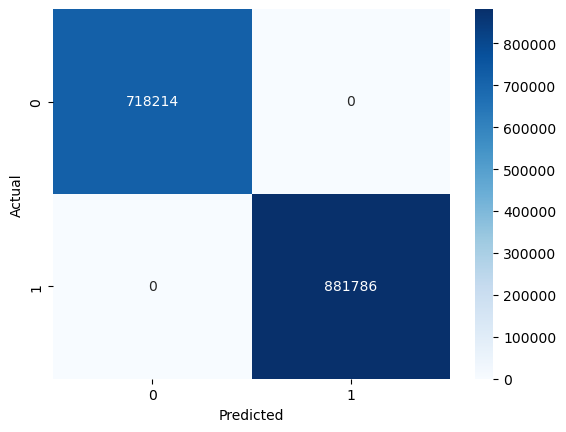

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(pandas_df['sentiment'], pandas_df['sentiment'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
#Adding a third label for display neutrality between the polarised thresholds:

# Initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Create get_sentiment function
def get_sentiment(text, pos_threshold=0.1, neg_threshold=-0.1):
    scores = analyzer.polarity_scores(text)
    
    # Classify as positive, negative, or neutral based on thresholds
    if scores['compound'] > pos_threshold:
        sentiment = 'positive'
    elif scores['compound'] < neg_threshold:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return scores['compound'], sentiment

# Apply get_sentiment function
pandas_df['sentiment_score'], pandas_df['sentiment'] = zip(*pandas_df['text'].apply(get_sentiment))

# Display the DataFrame
pandas_df.head()

,index,date,text,sentiment,sentiment_score
0,0,2009-04-07 05:19:45,a11 thats bummer shoulda got david carr third day,negative,-0.3818
1,1,2009-04-07 05:19:49,upset cant update facebook texting it11 might ...,negative,-0.7269
2,2,2009-04-07 05:19:53,dived many time ball managed save rest go bound,positive,0.4939
3,3,2009-04-07 05:19:57,whole body feel itchy like fire,negative,-0.2500
4,4,2009-04-07 05:19:57,behaving im mad cant see,negative,-0.4939


In [31]:
# Initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Create get_sentiment function
def get_sentiment(text, pos_threshold=0.1, neg_threshold=-0.1, neu_threshold=0.1):
    scores = analyzer.polarity_scores(text)
    
    # Classify as positive, negative, or neutral based on thresholds
    if scores['compound'] > pos_threshold:
        sentiment = 'positive'
    elif scores['compound'] < neg_threshold:
        sentiment = 'negative'
    elif abs(scores['compound']) <= neu_threshold:
        sentiment = 'neutral'
    else:
        sentiment = None
    
    return scores['compound'], sentiment

# Apply get_sentiment function
pandas_df['sentiment_score'], pandas_df['label'] = zip(*pandas_df['text'].apply(get_sentiment))

# Display the DataFrame
pandas_df.head()

,index,date,text,sentiment,sentiment_score,label
0,0,2009-04-07 05:19:45,a11 thats bummer shoulda got david carr third day,0,-0.3818,negative
1,1,2009-04-07 05:19:49,upset cant update facebook texting it11 might ...,0,-0.7269,negative
2,2,2009-04-07 05:19:53,dived many time ball managed save rest go bound,1,0.4939,positive
3,3,2009-04-07 05:19:57,whole body feel itchy like fire,0,-0.2500,negative
4,4,2009-04-07 05:19:57,behaving im mad cant see,0,-0.4939,negative


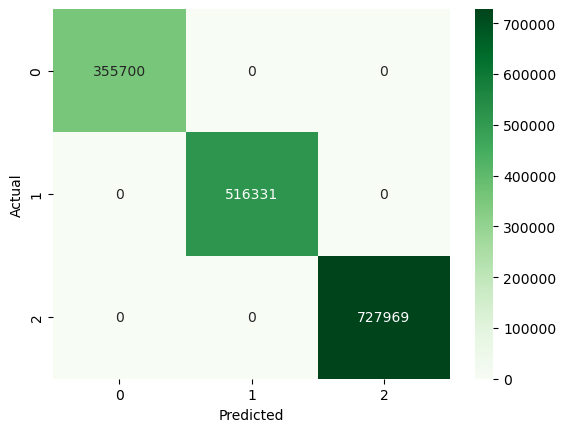

In [40]:
cm = confusion_matrix(pandas_df['label'], pandas_df['label'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
#Dist of sentiment:

pandas_df['label'].value_counts()

positive    727969
neutral     516331
negative    355700
Name: label, dtype: int64

In [37]:
# Convert 'date' column to datetime type
pandas_df['date'] = pd.to_datetime(pandas_df['date'])

# Create a new column with the date only
pandas_df['date_only'] = pandas_df['date'].dt.date

# Check the frequency of daily records
daily_frequency = pandas_df['date_only'].value_counts().sort_index()

# Display the frequency of daily records
print("Daily Frequency:\n", daily_frequency)

# Identify missing dates
all_dates = pd.date_range(start=pandas_df['date_only'].min(), end=pandas_df['date_only'].max(), freq='D')
missing_dates = all_dates[~all_dates.isin(pandas_df['date_only'])]

# Display missing dates
print("\nMissing Dates:\n", missing_dates)

Daily Frequency:
 2009-04-07     20671
2009-04-18     17154
2009-04-19     32648
2009-04-20     18447
2009-04-21     11105
2009-05-02     31096
2009-05-03     26568
2009-05-04     28300
2009-05-10     31551
2009-05-11      6217
2009-05-12      4186
2009-05-14     21526
2009-05-17     41205
2009-05-18     44564
2009-05-22     41206
2009-05-24       169
2009-05-25       169
2009-05-27     11619
2009-05-29     60227
2009-05-30    104484
2009-05-31    105986
2009-06-01     95449
2009-06-02     77776
2009-06-03     60139
2009-06-04      4638
2009-06-05     34735
2009-06-06    104793
2009-06-07    111893
2009-06-08     18566
2009-06-14       500
2009-06-15     83309
2009-06-16     87524
2009-06-17     44031
2009-06-18     43322
2009-06-19     42964
2009-06-20     45582
2009-06-21     30677
2009-06-22      8313
2009-06-23     18605
2009-06-24      2093
2009-06-25     25993
Name: date_only, dtype: int64

Missing Dates:
 DatetimeIndex(['2009-04-08', '2009-04-09', '2009-04-10', '2009-04-11',
   

In [42]:

print(pandas_df.info())
pandas_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   index            1600000 non-null  int32         
 1   date             1600000 non-null  datetime64[ns]
 2   text             1600000 non-null  object        
 3   sentiment        1600000 non-null  int64         
 4   sentiment_score  1600000 non-null  float64       
 5   label            1600000 non-null  object        
 6   date_only        1600000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 79.3+ MB
None


,index,date,text,sentiment,sentiment_score,label,date_only
0,0,2009-04-07 05:19:45,a11 thats bummer shoulda got david carr third day,0,-0.3818,negative,2009-04-07
1,1,2009-04-07 05:19:49,upset cant update facebook texting it11 might ...,0,-0.7269,negative,2009-04-07
2,2,2009-04-07 05:19:53,dived many time ball managed save rest go bound,1,0.4939,positive,2009-04-07
3,3,2009-04-07 05:19:57,whole body feel itchy like fire,0,-0.2500,negative,2009-04-07
4,4,2009-04-07 05:19:57,behaving im mad cant see,0,-0.4939,negative,2009-04-07


### Tokenization



In [18]:
# Show the result
#tweets_test.show(5,truncate=False)

+-----+-------------------+-----------------------------------------------------------------------------------------------------------+
|index|date               |text                                                                                                       |
+-----+-------------------+-----------------------------------------------------------------------------------------------------------+
|0    |2009-04-07 05:19:45|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                  |
|1    |2009-04-07 05:19:49|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah|
|2    |2009-04-07 05:19:53| i dived many times for the ball managed to save   the rest go out of bounds                               |
|3    |2009-04-07 05:19:57|my whole body feels itchy and like its on fire                                                             |
|4    |2009-04-07 05:19:57| no its not behaving 

#### Sentiment extration using SparkNLP library/pipeline

The sentiment analysis results will be stored in the 'sentiment.result' column once the data is preprocessed.

This pipeline uses the DocumentAssembler to assemble the words into documents, which is required for the Spark NLP SentimentDetector. Then, it applies the sentiment analysis using the trained model.

In [39]:
#!pip install sparknlp

In [29]:
#from sparknlp.pretrained import PretrainedPipeline

#pipeline = PretrainedPipeline("analyze_sentiment")

In [21]:
#from pyspark.sql.functions import lit

# Assuming your existing DataFrame is named `tweets_df` and tokenized words are in the column "words"
# Add a label column (e.g., 1 for positive, 0 for negative)
#labeled_df = tweets_df.withColumn("label", lit(1))  # possibvle to customize this based on sentiment classes

In [22]:
#from pyspark.sql.functions import concat_ws

# Combine tokenized words into a single column
#labeled_df = labeled_df.withColumn("combined_text", concat_ws(" ", "words"))

In [28]:
#from sparknlp.annotator import SentimentDetector

# SentimentDetector setup
#sentiment_detector = SentimentDetector() \
 #   .setInputCols(["combined_text", "words"]) \
   # .setOutputCol("sentiment")

# Create a new pipeline with the SentimentDetector
#pipeline_sentiment = Pipeline(stages=[sentiment_detector])

# Apply sentiment detection
#analyzed_df = pipeline_sentiment.fit(labeled_df).transform(labeled_df)

# Show the results
#analyzed_df.select("combined_text", "sentiment.result", "label").show(truncate=False)


In [30]:
#!pip install vaderSentiment
#error: externally-managed-environment

the main differences between the Pandas & PySpark, operations on Pyspark run faster than Pandas due to its distributed nature and parallel execution on multiple cores and machines.

In other words, pandas run operations on a single node whereas PySpark runs on multiple machines. If you are working on a Machine Learning application where you are dealing with larger datasets, PySpark processes operations many times faster than pandas.

scaling a cluster involves a trade-off between performance and cost. Adding more resources may improve performance, but it also increases infrastructure costs. It's essential to find the right balance based on your application's requirements and budget constraints.

The VADER sentiment analyzer is a simple rule-based model that works well for social media text. If you need more advanced sentiment analysis, you might want to explore machine learning-based approaches, such as using pre-trained models like BERT or spaCy.

"By far the most popular and comprehensive library, to my knowledge, for Spark-native distributed NLP, is spark-nlp from John Snow Labs. https://nlp.johnsnowlabs.com/ It is open source (but with commercial support options) and has a whole lot of functionality.

You can also use spacy, nltk, and other non-Spark NLP libraries with Spark, by writing pandas UDFs that leverage these libraries, then applying them to data with Spark."https://community.databricks.com/t5/machine-learning/what-are-best-nlp-libraries-to-use-with-spark/td-p/24033#:~:text=You%20can%20also%20use%20spacy,them%20to%20data%20with%20Spark.


- store cleaned dataset back to hbase/mysql


#### Importing dataset from HBase using a Connector.